# EDA and Feature Engineering

<div style="background-color: rgb(33,150,243); padding: 15px; border-radius: 5px;">
In this notebook, Exploratory Data Analysis (EDA) and feature engineering are performed to better understand patterns in taxi demand and weather influences. Temporal features (e.g., hour of day, day of week) and weather-related features (e.g., temperature, precipitation) are created to enhance model accuracy.
</div>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from statsmodels.tsa.seasonal import seasonal_decompose

<div style="background-color: rgb(120, 150, 180); padding: 15px; border-radius: 5px;">
Note (add features) <br>
    - taxi trip duration <br>
    - month<br>
    - day of month<br>
    - day of week<br>
    - hour<br>
    - time of the day<br>
    - weekday/weekend<br>
    - lagged features<br>
</div>

## Helper Functions

In [2]:
def get_time_of_day(hour):
    """
    Helps create time of day feature
    """
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

In [3]:
def split_data(df, weather_df, train_size=0.8):
    """
    Split data while maintaining sequence
    """
    split_idx = int(train_size * len(weather_df))
    split_time = weather_df.iloc[split_idx].time
    train_df = df[df.tpep_pickup_datetime < str(split_time)].copy()
    test_df = df[df.tpep_pickup_datetime >= str(split_time)].copy()
    train_weather_df = weather_df[weather_df.time < str(split_time)].copy()
    test_weather_df = weather_df[weather_df.time >= str(split_time)].copy()
    return train_df, test_df, train_weather_df, test_weather_df

In [4]:
def aggregate_trip_data(df):
    """
    Aggregates all trip data rows into hour wise data
    """
    df = df.copy()
    df = df.sort_values('tpep_pickup_datetime')
    df = df.reset_index(drop=True)
    df['trip_duration'] = ((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds / 60)
    df['demand_count'] = 1
    a_df = df[['tpep_pickup_datetime', 'passenger_count', 'trip_distance', 'trip_duration']].resample('1h', on='tpep_pickup_datetime').median()
    b_df = df[['tpep_pickup_datetime', 'PULocationID', 'DOLocationID']].resample('1h', on='tpep_pickup_datetime').apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    c_df = df[['tpep_pickup_datetime', 'demand_count']].resample("1h",  on='tpep_pickup_datetime').sum()
    df = pd.concat([a_df, b_df, c_df], axis=1)
    df = df.reset_index()
    df = df.rename(columns={'tpep_pickup_datetime': 'time'})
    return df

In [5]:
def add_temporal_features(df):
    """
    Adds temporal features extracted from time
    """
    df = df.copy()
    df['hour'] = df['time'].dt.hour
    df['time_of_day'] = df['hour'].apply(get_time_of_day)
    df['time_of_day'] = pd.Categorical(
        df['time_of_day'],
        categories=['Morning', 'Afternoon', 'Evening', 'Night'],
        ordered=True
    )
    df['day_of_week'] = df['time'].dt.strftime('%w')
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in ["Saturday", "Sunday"] else 0).astype('category')
    df['day_of_month'] = df['time'].dt.day
    df['month'] = df['time'].dt.strftime('%m')
    return df

In [6]:
def impute_values(df):
    """
    Imputes missing data
    """
    df = df.copy()
    print("Before imputaion")
    print(df.info())
    df['demand_count'] = df['demand_count'].replace(0, np.nan)
    df['passenger_count'] = df['passenger_count'].ffill()
    df['trip_distance'] = df['trip_distance'].ffill()
    df['trip_duration'] = df['trip_duration'].ffill()
    df['demand_count'] = df['demand_count'].ffill()
    df['PULocationID'] = df['PULocationID'].fillna(df['PULocationID'].mode()[0])
    df['DOLocationID'] = df['DOLocationID'].fillna(df['DOLocationID'].mode()[0])
    print("After imputaion")
    print(df.info())
    return df

In [7]:
def add_lagged_features(df):
    """
    Adds lag and ewma features
    """
    df = df.copy()
    df['lag_3h'] = df['demand_count'].shift(3).fillna(0)
    df['lag_6h'] = df['demand_count'].shift(6).fillna(0)
    df['lag_12h'] = df['demand_count'].shift(12).fillna(0)
    df['ewma_3h'] = df['demand_count'].shift(1).ewm(span=3, adjust=False).mean()
    df['ewma_6h'] = df['demand_count'].shift(1).ewm(span=6, adjust=False).mean()
    df['ewma_12h'] = df['demand_count'].shift(1).ewm(span=12, adjust=False).mean()
    return df

## Loading Data

In [8]:
trip_df = pd.read_csv('../data/clean/clean_trip_data_dropna.csv',
                 parse_dates=[
                     'tpep_pickup_datetime',
                     'tpep_dropoff_datetime'
                 ])
trip_df = trip_df.sort_values('tpep_pickup_datetime')
trip_df = trip_df.reset_index(drop=True)

In [9]:
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47980 entries, 0 to 47979
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   47980 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  47980 non-null  datetime64[ns]
 2   passenger_count        47980 non-null  float64       
 3   trip_distance          47980 non-null  float64       
 4   PULocationID           47980 non-null  int64         
 5   DOLocationID           47980 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 2.2 MB


In [10]:
weather_df = pd.read_csv('../data/clean/clean_weather_data.csv', parse_dates=['date'])

In [11]:
weather_df = weather_df.sort_values('date')
weather_df = weather_df.reset_index(drop=True)
weather_df = weather_df.rename(columns={'date': 'time'})

In [12]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            8760 non-null   datetime64[ns]
 1   temperature_2m  8760 non-null   float64       
 2   precipitation   8760 non-null   float64       
 3   rain            8760 non-null   float64       
 4   snowfall        8760 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 342.3 KB


## Split Data

The data is split into train and test set as feature engineering requires aggregation. As per golden rule, we should not let the test and train data influence each other.

In [13]:
train_trip_df, test_trip_df, train_weather_df, test_weather_df = split_data(trip_df, weather_df, train_size=0.8)

In [14]:
train_trip_df.shape

(36884, 6)

In [15]:
test_trip_df.shape

(11096, 6)

In [16]:
train_weather_df.shape

(7008, 5)

In [17]:
test_weather_df.shape

(1752, 5)

## Feature Engineering

#### Doing Data Aggregation

In [18]:
train_trip_df = aggregate_trip_data(train_trip_df)
test_trip_df = aggregate_trip_data(test_trip_df)

In [19]:
train_trip_df.shape, test_trip_df.shape

((7007, 7), (1752, 7))

In [20]:
train_trip_df.describe()

,time,passenger_count,trip_distance,trip_duration,PULocationID,DOLocationID,demand_count
count,7007,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,7007.000000
mean,2023-05-26 23:00:00,1.089577,5.591236,26.188145,125.834998,98.481185,5.263879
min,2023-01-01 00:00:00,1.000000,0.010000,0.000000,3.000000,1.000000,0.000000
25%,2023-03-14 23:30:00,1.000000,2.860000,17.000000,51.000000,41.000000,1.000000
50%,2023-05-26 23:00:00,1.000000,4.600000,25.000000,126.000000,74.000000,3.000000
75%,2023-08-07 22:30:00,1.000000,7.350000,33.000000,182.000000,159.000000,8.000000
max,2023-10-19 22:00:00,6.000000,100.000000,1328.000000,259.000000,265.000000,30.000000
std,NaN,0.395080,4.087827,22.885673,79.307181,75.540585,5.349598


#### Drop NaNs - basic data

In [21]:
basic_train_trip_df = train_trip_df.dropna()
basic_test_trip_df = test_trip_df.dropna()

In [22]:
basic_train_trip_df.to_csv('../data/clean/basic_train.csv', index=False)
basic_test_trip_df.to_csv('../data/clean/basic_test.csv', index=False)

In [23]:
basic_train_trip_df.shape, basic_test_trip_df.shape

((6006, 7), (1474, 7))

#### Data Imputation using ffill

In [24]:
imputed_train_trip_df = impute_values(train_trip_df)

Before imputaion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7007 entries, 0 to 7006
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             7007 non-null   datetime64[ns]
 1   passenger_count  6006 non-null   float64       
 2   trip_distance    6006 non-null   float64       
 3   trip_duration    6006 non-null   float64       
 4   PULocationID     6006 non-null   float64       
 5   DOLocationID     6006 non-null   float64       
 6   demand_count     7007 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 383.3 KB
None
After imputaion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7007 entries, 0 to 7006
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             7007 non-null   datetime64[ns]
 1   passenger_count  7007 non-null   float

In [25]:
imputed_test_trip_df = impute_values(test_trip_df)

Before imputaion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             1752 non-null   datetime64[ns]
 1   passenger_count  1474 non-null   float64       
 2   trip_distance    1474 non-null   float64       
 3   trip_duration    1474 non-null   float64       
 4   PULocationID     1474 non-null   float64       
 5   DOLocationID     1474 non-null   float64       
 6   demand_count     1752 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 95.9 KB
None
After imputaion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             1752 non-null   datetime64[ns]
 1   passenger_count  1752 non-null   float6

In [26]:
imputed_train_trip_df.shape, imputed_test_trip_df.shape

((7007, 7), (1752, 7))

In [27]:
imputed_train_trip_df.to_csv('../data/clean/imputed_train.csv', index=False) # but use basic_test for testing
imputed_test_trip_df.to_csv('../data/clean/imputed_test.csv', index=False)

#### Adding temporal features

In [28]:
# non imputed data with temporal features
basic_train_trip_with_temp_df = add_temporal_features(basic_train_trip_df)

In [29]:
basic_test_trip_with_temp_df = add_temporal_features(basic_test_trip_df)

In [30]:
basic_train_trip_with_temp_df.shape, basic_test_trip_with_temp_df.shape

((6006, 13), (1474, 13))

In [31]:
basic_train_trip_with_temp_df.to_csv('../data/clean/basic_train_with_temp.csv', index=False)
basic_test_trip_with_temp_df.to_csv('../data/clean/basic_test_with_temp.csv', index=False)

In [32]:
# imputed data with temporal features
imputed_train_trip_with_temp_df = add_temporal_features(imputed_train_trip_df)
imputed_test_trip_with_temp_df = add_temporal_features(imputed_test_trip_df)

In [33]:
imputed_train_trip_with_temp_df.shape, imputed_test_trip_with_temp_df.shape

((7007, 13), (1752, 13))

In [34]:
imputed_train_trip_with_temp_df.to_csv('../data/clean/imputed_train_with_temp.csv', index=False)
imputed_test_trip_with_temp_df.to_csv('../data/clean/imputed_test_with_temp.csv', index=False)

#### Adding lagged features

In [35]:
# only works with imputed data because we need lags/historic values

In [36]:
imputed_train_trip_lags_df = add_lagged_features(imputed_train_trip_df)

In [37]:
imputed_test_trip_df = impute_values(test_trip_df)

Before imputaion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             1752 non-null   datetime64[ns]
 1   passenger_count  1474 non-null   float64       
 2   trip_distance    1474 non-null   float64       
 3   trip_duration    1474 non-null   float64       
 4   PULocationID     1474 non-null   float64       
 5   DOLocationID     1474 non-null   float64       
 6   demand_count     1752 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 95.9 KB
None
After imputaion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             1752 non-null   datetime64[ns]
 1   passenger_count  1752 non-null   float6

In [38]:
imputed_test_trip_lags_df = add_lagged_features(imputed_test_trip_df) # have to make imputed test in order to add lags to it

In [39]:
imputed_train_trip_lags_df.shape, imputed_test_trip_lags_df.shape

((7007, 13), (1752, 13))

In [40]:
imputed_train_trip_lags_df.to_csv('../data/clean/imputed_train_with_lags.csv', index=False)
imputed_test_trip_lags_df.to_csv('../data/clean/imputed_test_with_lags.csv', index=False)

In [41]:
# to have both temporal and lagged features
imputed_train_trip_lags_with_temp_df = add_lagged_features(imputed_train_trip_with_temp_df)
imputed_test_trip_lags_with_temp_df = add_lagged_features(imputed_test_trip_with_temp_df)

In [42]:
imputed_train_trip_lags_with_temp_df.shape, imputed_test_trip_lags_with_temp_df.shape

((7007, 19), (1752, 19))

In [43]:
imputed_train_trip_lags_with_temp_df.to_csv('../data/clean/imputed_train_with_temp_with_lags.csv', index=False)
imputed_test_trip_lags_with_temp_df.to_csv('../data/clean/imputed_test_with_temp_with_lags.csv', index=False)

## Exploratory Data Analysis

In [44]:
def plot_taxi_trips_per_hour(df):
    """
    Plots number of trips per hour in a day
    """
    plt.figure(figsize=(10, 5))
    df.groupby('hour', observed=True).demand_count.mean().plot(kind='bar', color='C0', edgecolor='black')
    plt.title('Number of Taxi Trips per Hour (Day Trend)')
    plt.xlabel('Hour of the Day')
    plt.xticks(rotation=0)
    plt.ylabel('Number of Trips')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

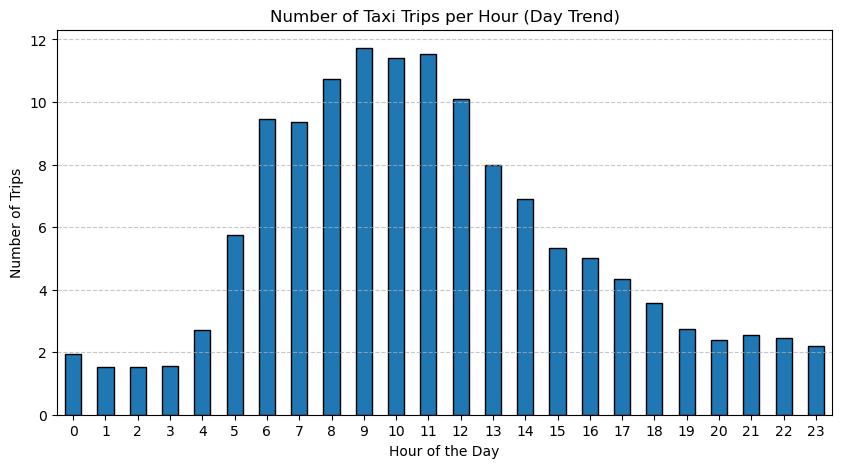

In [45]:
plot_taxi_trips_per_hour(basic_train_trip_with_temp_df)

In [46]:
def plot_taxi_trips_per_time_of_day(df):
    """
    Plots number of trips per time range
    """
    plt.figure(figsize=(10, 5))
    df.groupby('time_of_day', observed=True).demand_count.sum().plot(kind='bar', edgecolor='black')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title('Number of Taxi Trips by Time of the Day (Day Trend)')
    plt.xlabel('Time of the Day')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=0)
    
    legend_labels = [
        Patch(label='Morning: 6:00 AM - 11:59 AM'),
        Patch(label='Afternoon: 12:00 PM - 3:59 PM'),
        Patch(label='Evening: 4:00 PM - 9:59 PM'),
        Patch(label='Night: 10:00 PM - 5:59 AM')
    ]
    plt.legend(handles=legend_labels, loc='upper right')
    plt.savefig('../figures/avg_trips_per_time_of_day.png', bbox_inches = 'tight')
    plt.show()

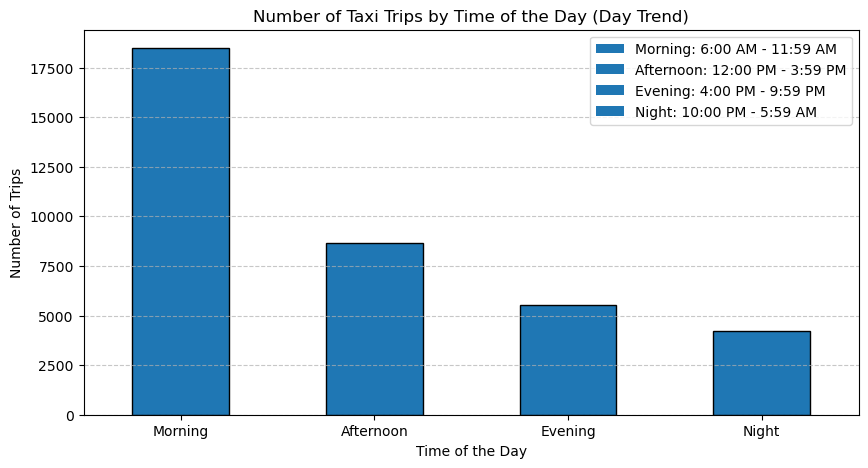

In [47]:
plot_taxi_trips_per_time_of_day(basic_train_trip_with_temp_df)

In [83]:
def plot_taxi_trips_per_day_of_week(df):
    """
    Plots number of trips per day of the week
    """
    plt.figure(figsize=(10, 5))
    df.groupby('day_of_week', observed=True)['demand_count'].mean().plot(kind='bar', color='C0', edgecolor='black')
    plt.title('Number of Taxi Trips per Day of the Week (Week Trend)')
    plt.xlabel('Day of the Week')
    plt.xticks(rotation=0)
    plt.ylabel('Number of Trips')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    legend_labels = [
        Patch(label='Sunday to Saturday')
    ]
    plt.legend(handles=legend_labels, loc='upper right')
    plt.savefig('../figures/avg_trips_per_day_of_week.png', bbox_inches = 'tight')
    plt.show()

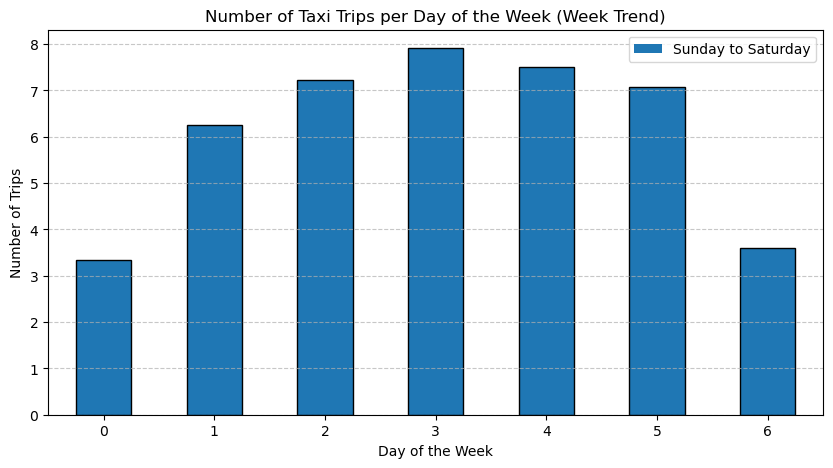

In [84]:
plot_taxi_trips_per_day_of_week(basic_train_trip_with_temp_df)

In [50]:
def plot_avg_trip_duration_per_day_of_week(df):
    """
    Plots avg trip duration per hour in a day
    """
    plt.figure(figsize=(10, 5))
    df.groupby('day_of_week', observed=True)['trip_duration'].mean().plot(kind='bar', color='C0', edgecolor='black')
    plt.title('Average trip duration per Day of the Week (Week Trend)')
    plt.xlabel('Day of the Week')
    plt.xticks(rotation=0)
    plt.ylabel('Number of Trips')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    legend_labels = [
        Patch(label='Sunday to Saturday')
    ]
    plt.legend(handles=legend_labels, loc='upper right')
    plt.savefig('../figures/avg_trip_duration_per_day_of_week.png', bbox_inches = 'tight')
    plt.show()

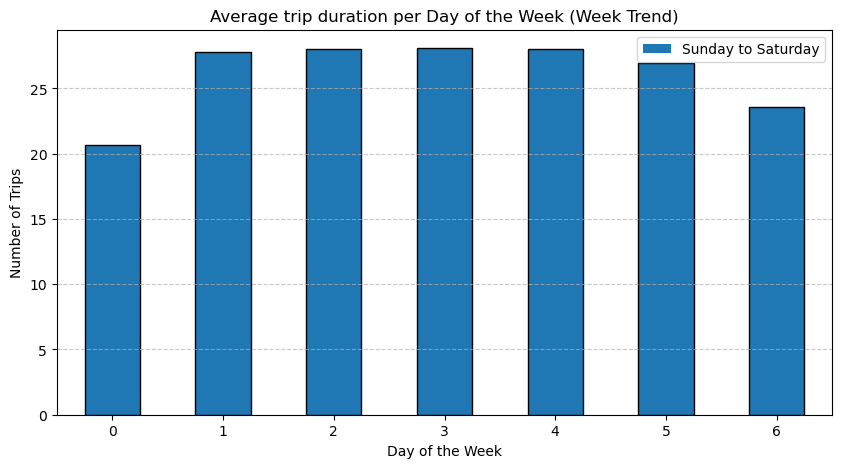

In [51]:
plot_avg_trip_duration_per_day_of_week(basic_train_trip_with_temp_df)

In [52]:
def plot_taxi_trips_per_day_of_month(df):
    """
    Plots number of trips per day of the month
    """
    plt.figure(figsize=(10, 5))
    df.groupby('day_of_month', observed=True)['demand_count'].mean().plot(kind='bar', color='C0', edgecolor='black')
    plt.title('Number of Taxi Trips per Day of the Month (Month Trend)')
    plt.xlabel('Day of the Month')
    plt.xticks(rotation=0)
    plt.ylabel('Number of Trips')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('../figures/avg_trips_per_day_of_month.png', bbox_inches = 'tight')
    plt.show()

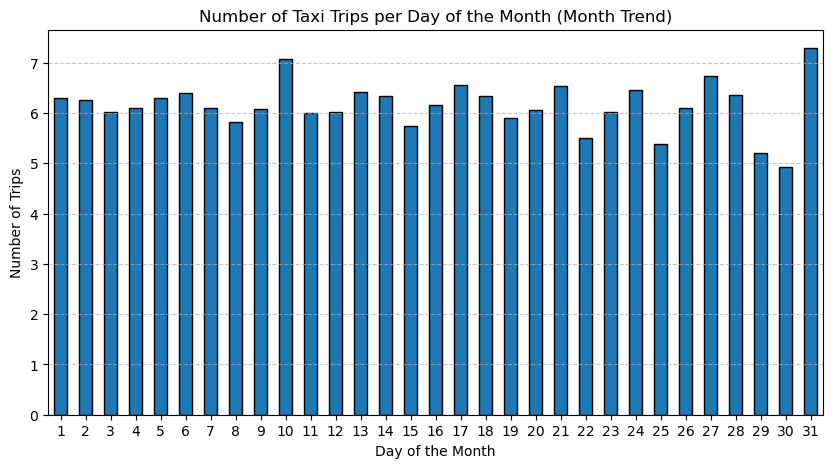

In [53]:
plot_taxi_trips_per_day_of_month(basic_train_trip_with_temp_df)

In [54]:
def plot_taxi_trips_per_month(df):
    """
    Plots number of trips per month of the year
    """
    plt.figure(figsize=(10, 5))
    df.groupby('month', observed=True)['demand_count'].mean().plot(kind='bar', color='C0', edgecolor='black', width=0.6)
    plt.title('Number of Taxi Trips per Month (Year Trend)')
    plt.xlabel('Month')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45, ha='center')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('../figures/total_trips_per_month.png', bbox_inches = 'tight')
    plt.show()

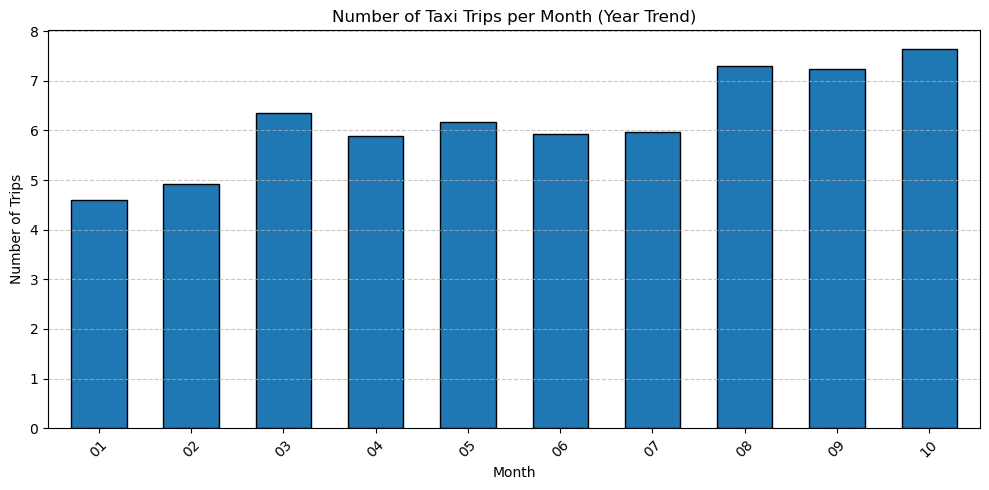

In [55]:
plot_taxi_trips_per_month(basic_train_trip_with_temp_df)

In [56]:
def plot_taxi_trips_per_day_annual(df, title):
    """
    Plots number of trips 
    """
    plt.figure(figsize=(10, 5))
    df.resample('D', on='time')['demand_count'].sum().plot(kind='line', marker='o', color='C0')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Number of Trips')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('../figures/' + title.lower().replace(' ', '_') + '.png', bbox_inches = 'tight')
    plt.show()

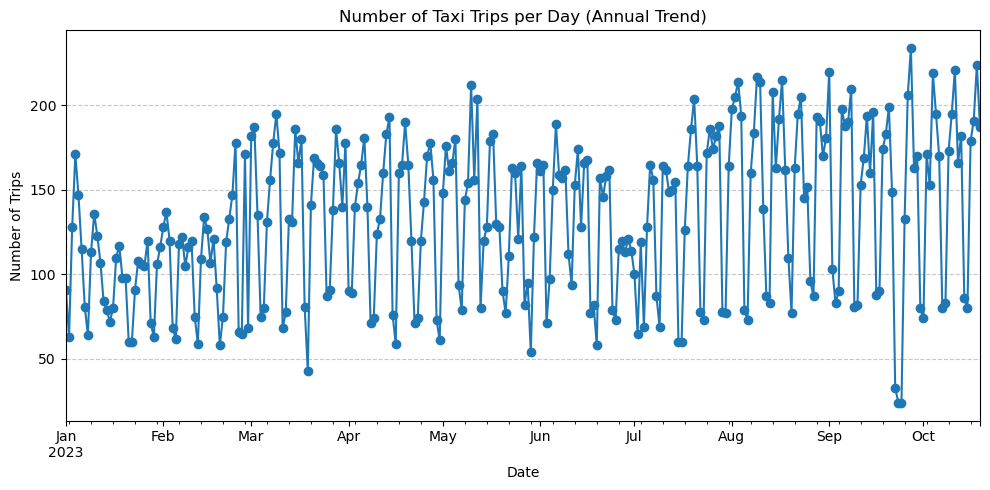

In [57]:
plot_taxi_trips_per_day_annual(imputed_train_trip_df, 'Number of Taxi Trips per Day (Annual Trend)')

#### Understanding September Anomaly

In [58]:
sept_anomaly_df = train_trip_df[(train_trip_df['time'] > '2023-09-20') & (train_trip_df['time'] < '2023-09-28')]

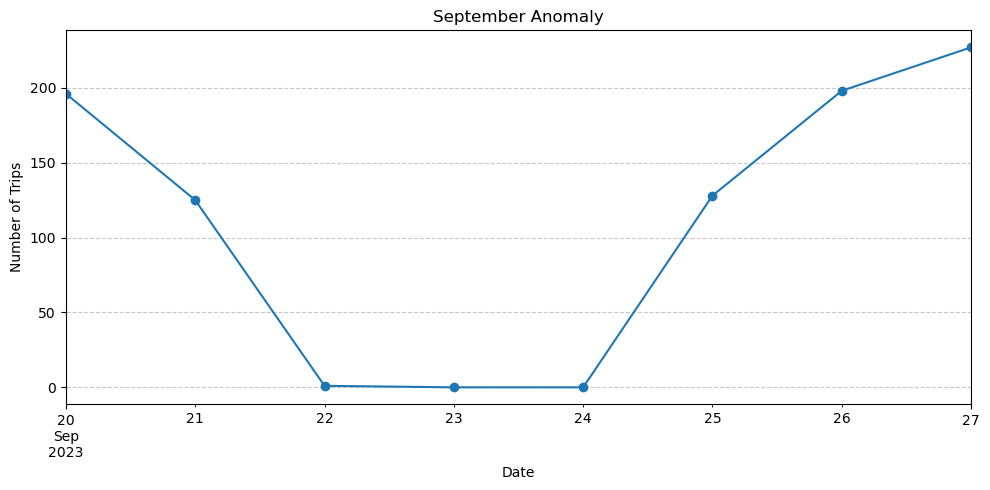

In [59]:
plot_taxi_trips_per_day_annual(sept_anomaly_df, "September Anomaly")

In [60]:
def check_seasonality(df, period=24):
    """
    Performs seasonal decomposition to find trend and seasonality in data
    """
    fig, axes = plt.subplots(4, 1, figsize=(10, 5), sharex=True)
    decomposition = seasonal_decompose(df.set_index('time')['demand_count'], model='multiplicative', period=period)
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    fig.suptitle(f'Seasonal Decomposition - period: {period} hours')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'../figures/seasonality-period-{period}.png', bbox_inches = 'tight')
    plt.show()

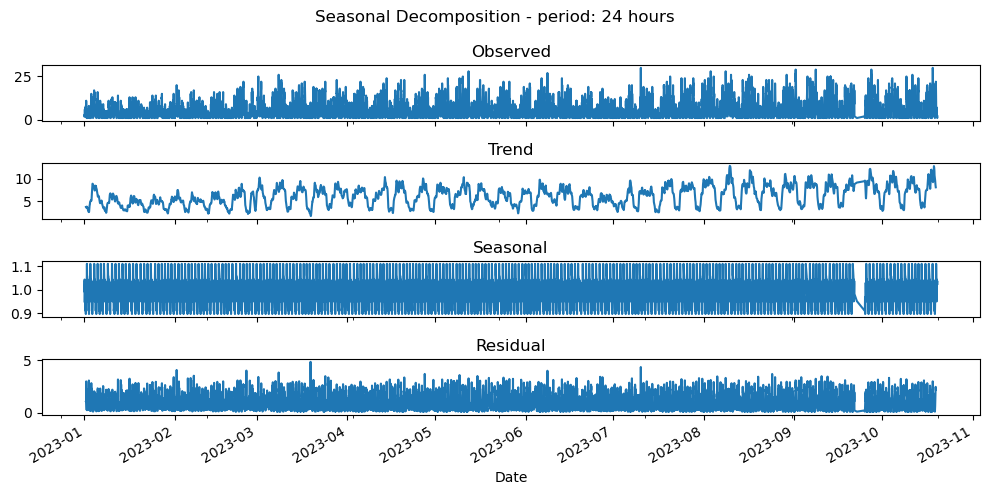

In [61]:
check_seasonality(basic_train_trip_df, 24)

In [62]:
def plot_weather_data(df, span=10):
    """
    Plots weather data
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    df = df.copy()
    df = df.set_index('time')
    cols = df.columns

    ewma_col1 = df[cols[0]].ewm(span=span, adjust=False).mean()
    ax1.plot(df.index, ewma_col1, label=f'{cols[0]} (EWMA)', color='C1')
    ax1.set_ylabel(f'{cols[0]} (EWMA) degree celcius', color='C1')
    ax1.tick_params(axis='y', labelcolor='C1')

    ax2 = ax1.twinx()
    ewma_col2 = df[cols[1]].ewm(span=span, adjust=False).mean()
    ax2.plot(df.index, ewma_col2, label=f'{cols[1]} (EWMA)', color='C2')
    ax2.set_ylabel(f'{cols[1]} (EWMA) mm', color='C2')
    ax2.tick_params(axis='y', labelcolor='C2')

    ax3 = ax1.twinx()
    ewma_col3 = df[cols[2]].ewm(span=span, adjust=False).mean()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(df.index, ewma_col3, label=f'{cols[2]} (EWMA)', color='C3')
    ax3.set_ylabel(f'{cols[2]} (EWMA) mm', color='C3')
    ax3.tick_params(axis='y', labelcolor='C3')

    ax4 = ax1.twinx()
    ewma_col4 = df[cols[3]].ewm(span=span, adjust=False).mean()
    ax4.spines['right'].set_position(('outward', 120))
    ax4.plot(df.index, ewma_col4, label=f'{cols[3]} (EWMA)', color='C4')
    ax4.set_ylabel(f'{cols[3]} (EWMA) cm', color='C4')
    ax4.tick_params(axis='y', labelcolor='C4')

    plt.title('Exponentially Weighted Moving Average Weather columns')
    fig.tight_layout()
    ax1.set_xlabel('Time')
    plt.savefig('../figures/weather_trend.png', bbox_inches = 'tight')
    plt.show()

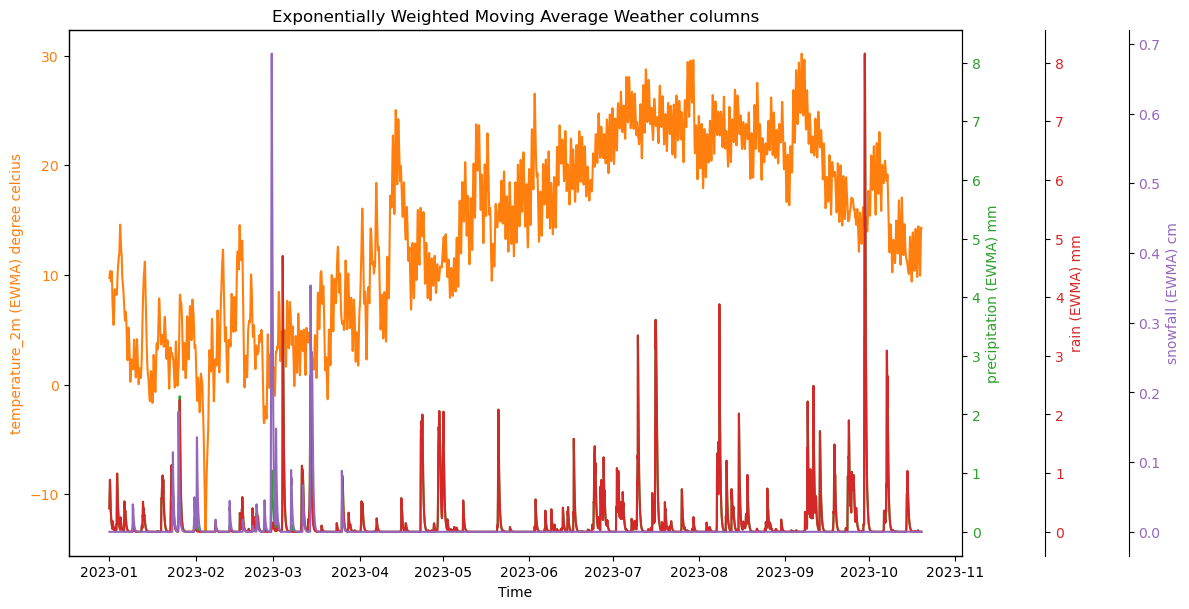

In [63]:
plot_weather_data(train_weather_df, span=15)

In [64]:
def plot_heatmap_day_of_month_per_month(df):
    """
    Plots correlation between day and month
    """
    plt.figure(figsize=(10, 5))
    grouped_month_day = df.groupby(["day_of_month", "month"], observed=True)['demand_count'].sum().reset_index(name="trips")
    pivot_month_day = grouped_month_day.pivot(index="day_of_month", columns="month", values="trips")
    pivot_month_day = pivot_month_day.sort_index().loc[::-1]  # Reverse the order of days for the y-axis
    
    plt.imshow(pivot_month_day, aspect='auto', cmap='coolwarm', interpolation='nearest')
    months = pivot_month_day.columns
    plt.xticks(ticks=np.arange(len(months)), labels=months, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(pivot_month_day.index)), labels=list(reversed(range(1, 32))), rotation=0)
    cbar = plt.colorbar()
    cbar.set_label('Number of Trips')
    plt.title('Daily Distribution of Trips per Month')
    plt.savefig('../figures/day_month_correlation.png', bbox_inches = 'tight')
    plt.xlabel('Month')
    plt.ylabel('Day')
    plt.show()

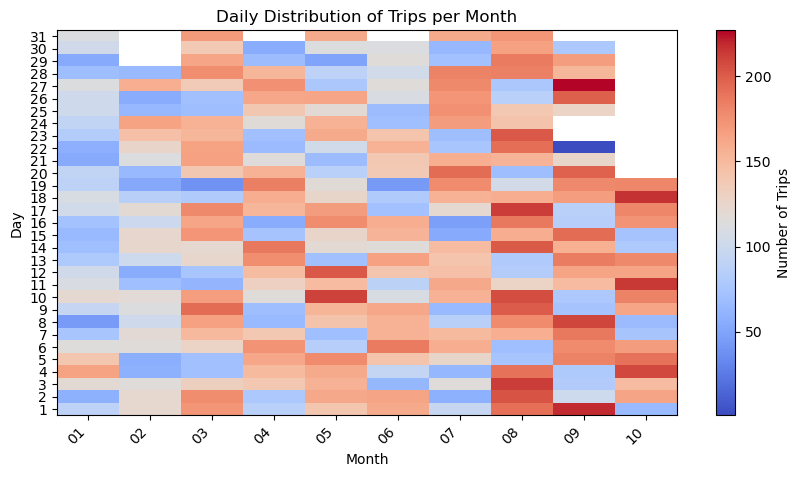

In [65]:
plot_heatmap_day_of_month_per_month(basic_train_trip_with_temp_df)

In [66]:
def plot_heatmap_hour_day_of_week(df):
    """
    Plots correlation between hour and day of the week
    """
    plt.figure(figsize=(10, 5))
    grouped_hour_day = df.groupby(["hour", "day_of_week"], observed=True)['demand_count'].sum().reset_index(name="trips")
    pivot_hour_day = grouped_hour_day.pivot(index="hour", columns="day_of_week", values="trips")
    pivot_hour_day = pivot_hour_day.sort_index().loc[::-1]  # Reverse the order of hours for the y-axis
    day_order = df['day_of_week'].cat.categories if hasattr(df['day_of_week'], 'cat') else sorted(df['day_of_week'].unique())
    plt.imshow(pivot_hour_day, aspect='auto', cmap='coolwarm', interpolation='nearest')
    plt.xticks(ticks=np.arange(len(day_order)), labels=day_order, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(pivot_hour_day.index)), labels=list(reversed(range(0, 24))))
    cbar = plt.colorbar()
    cbar.set_label('Number of Trips')
    plt.title('Hourly Distribution of Trips per Day of the Week')
    plt.savefig('../figures/hour_day_correlation.png', bbox_inches = 'tight')
    plt.xlabel('Day (Sunday to Saturday)')
    plt.ylabel('Hour')
    plt.show()

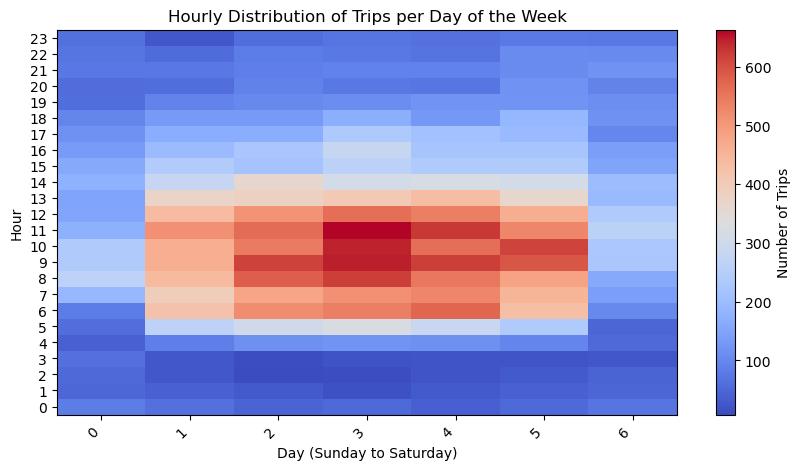

In [67]:
plot_heatmap_hour_day_of_week(basic_train_trip_with_temp_df)

In [68]:
def plot_avg_trips_hourly_day_of_week_lines(df):
    """
    Plots avg number of trips per hour for each day of the week
    """
    plt.figure(figsize=(10, 5))

    day_of_week_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

    for i, day in enumerate(day_of_week_order):
        df[df['day_of_week'] == str(i)].groupby('hour', observed=True)['demand_count'].mean().plot(kind='line',
                                                                                                   color=colors[i],
                                                                                                   label=day_of_week_order[i])

    plt.title('Average Number of Trips per Hour Across Days of the Week')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Number of Trips')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', title='Day of the Week')
    plt.savefig('../figures/avg_trips_per_hour_lineplot.png', bbox_inches = 'tight')
    plt.tight_layout()
    plt.show()

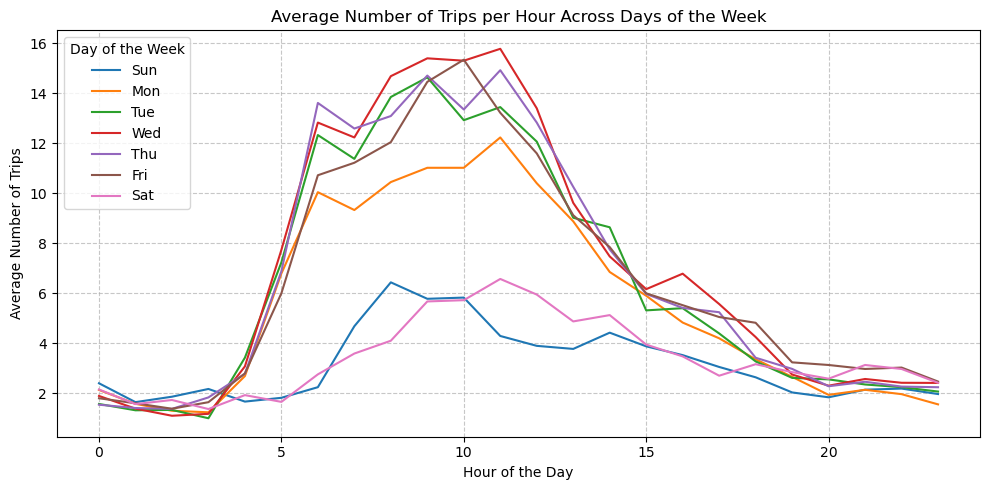

In [69]:
plot_avg_trips_hourly_day_of_week_lines(basic_train_trip_with_temp_df)

In [70]:
def plot_trips_day_of_week_by_time_of_day(df):
    """
    Plots time range distribution per day for the whole week
    """
    fig, ax = plt.subplots(figsize=(12, 4))

    day_of_week_order = df['day_of_week'].cat.categories if hasattr(df['day_of_week'], 'cat') else sorted(df['day_of_week'].unique())
    time_of_day_order = df['time_of_day'].cat.categories if hasattr(df['time_of_day'], 'cat') else sorted(df['time_of_day'].unique())
    colors = ['C0', 'C1', 'C2', 'C3']

    day_time_counts = df.groupby(['day_of_week', 'time_of_day'],
                                 observed=True)['demand_count'].mean().unstack().reindex(columns=time_of_day_order,
                                                                                         index=day_of_week_order)
    
    day_time_counts.plot(kind='bar', color=colors, edgecolor='black', width=0.8, ax=ax)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_title('Number of Trips per Day of the Week Divided by Time of the Day')
    ax.set_xlabel('Day (Sunday to Saturday)')
    ax.set_ylabel('Number of Trips')
    ax.set_xticks(range(len(day_time_counts.index)))
    ax.set_xticklabels(day_of_week_order, rotation=0)

    legend_labels = [
        Patch(color=colors[0], label='Morning: 6:00 AM - 11:59 AM'),
        Patch(color=colors[1], label='Afternoon: 12:00 PM - 3:59 PM'),
        Patch(color=colors[2], label='Evening: 4:00 PM - 9:59 PM'),
        Patch(color=colors[3], label='Night: 10:00 PM - 5:59 AM')
    ]
    ax.legend(handles=legend_labels, loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    plt.savefig('../figures/avg_trips_in_time_of_day_per_day.png', bbox_inches = 'tight')
    plt.tight_layout()
    plt.show()

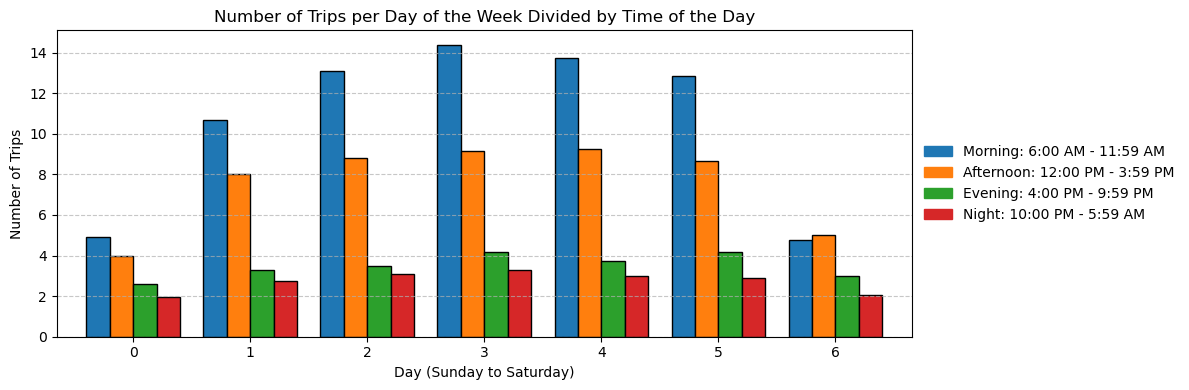

In [71]:
plot_trips_day_of_week_by_time_of_day(basic_train_trip_with_temp_df)

In [72]:
def plot_correlation_heatmap(df, title):
    """
    Plots correlation between features
    """
    numeric_df = df.select_dtypes(include=['int', 'float'])
    correlation_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 5))
    heatmap = plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
    
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Correlation Coefficient')

    plt.title('Correlation Matrix')
    plt.xticks(ticks=np.arange(len(correlation_matrix.columns)), labels=correlation_matrix.columns, rotation=90)
    plt.yticks(ticks=np.arange(len(correlation_matrix.index)), labels=correlation_matrix.index)
    plt.savefig('../figures/'+ title + '.png', bbox_inches = 'tight')
    plt.show()

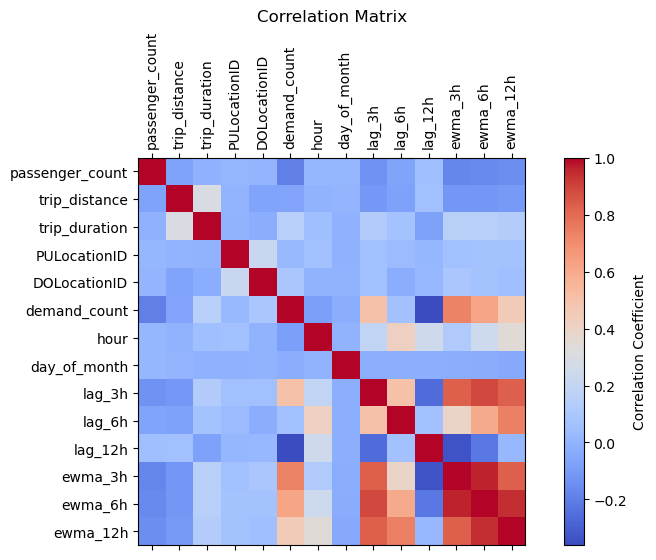

In [73]:
plot_correlation_heatmap(imputed_train_trip_lags_with_temp_df, 'trip_features_correlation')

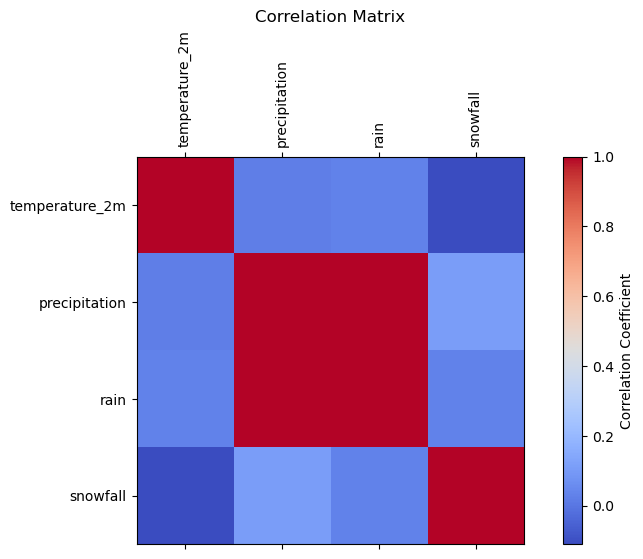

In [74]:
plot_correlation_heatmap(train_weather_df, 'weather_correlation')

## Data Consolidation

In [75]:
train_master_df = pd.merge(imputed_train_trip_lags_with_temp_df, train_weather_df, on='time', how='inner')

In [76]:
train_master_df.shape

(7007, 23)

In [77]:
test_master_df = pd.merge(imputed_test_trip_lags_with_temp_df, test_weather_df, on='time', how='inner')

In [78]:
test_master_df.shape

(1752, 23)

## Data Export

In [79]:
train_master_df.to_csv('../data/clean/imputed_train_with_temp_with_lags_with_weather.csv', index=False)

In [80]:
test_master_df.to_csv('../data/clean/imputed_test_with_temp_with_lags_with_weather.csv', index=False)